# MRTrix Preprocessing Pipeline
- via: https://andysbrainbook.readthedocs.io/en/latest/MRtrix/MRtrix_Course/MRtrix_04_Preprocessing.html
- General approach in this notebook: 
    - build an initial dataframe containing the subject ids
    - apply preprocessing steps, where each step creates a new subdirectory and/or file
        - if output files/subdirectories exist, do not run
        - existing output subdirectory should be moved/deleted in this case
    - filepaths of all data should be recorded in the `df_filepaths` dataframe
    - Some steps will require visual inspection and manual intervention
        - approach TBD...
        - possibility: gridsearch preprocessing approach to optimize based on output image parameters
        - output image parameters could be checked with fslutils/fslmaths + visual inspection

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets

from nipype.interfaces.dcm2nii import Dcm2nii
import nilearn
from nilearn import image, plotting
import nibabel as nib


In [3]:
# specify project directory
main_dir = '/media/forest/wd_1/data_CLMS/diffusion'

## Prep Data for Preprocessing
- specified `home_dir` should contain subdirectories, 1 for each subject at one timepoint (m00 or m24)
- each subdirectory should contain files with extension `.mif`

### Convert DCM files into nifti
-  dcm2nii: https://www.nitrc.org/plugins/mwiki/index.php/dcm2nii:MainPage
    - prereq: `sudo apt install mricron`
    - alternatively, can use the wrapper in nipype
        - https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.dcm2nii.html
- dcm files for each subject are stored inside the subdirectory: `1_dcm`


In [4]:
# specify subdirectory storing dcm files
dcm_dir = main_dir + '/1.1_dcm'

In [5]:
# create new dataframe to store file paths; subj id format: \w{3}_\d{3}_m\d{2}
subject_names = !ls $dcm_dir # dcm data should be stored in subdirectories named by subject
subject_dcm_dir = !ls -d $dcm_dir/* 

df_filepaths = pd.DataFrame({'subject_names': subject_names, 'dcm_path': subject_dcm_dir})
df_filepaths

,subject_names,dcm_path
0,aah_032_m00,/media/forest/wd_1/data_CLMS/diffusion/1.1_dcm...
1,aaj_034_m00,/media/forest/wd_1/data_CLMS/diffusion/1.1_dcm...
2,aao_039_m00,/media/forest/wd_1/data_CLMS/diffusion/1.1_dcm...
3,bbe_055_m00,/media/forest/wd_1/data_CLMS/diffusion/1.1_dcm...
4,ghi_007_m00,/media/forest/wd_1/data_CLMS/diffusion/1.1_dcm...
5,ijk_009_m00,/media/forest/wd_1/data_CLMS/diffusion/1.1_dcm...
6,mno_013_m00,/media/forest/wd_1/data_CLMS/diffusion/1.1_dcm...
7,pqr_016_m00,/media/forest/wd_1/data_CLMS/diffusion/1.1_dcm...
8,vwx_022_m00,/media/forest/wd_1/data_CLMS/diffusion/1.1_dcm...
9,xyz_024_m00,/media/forest/wd_1/data_CLMS/diffusion/1.1_dcm...


In [13]:
# process data from previously created dataframe
for subject, dcm in zip(df_filepaths['subject_names'], df_filepaths['dcm_path']):

    # if directory already exists, don't process
    nifti_dir_exists = ![ -d "{main_dir}/1.2_nifti/{subject}" ] && echo 'True';
    if nifti_dir_exists == ['True']:
        print(f'Subject: {subject}')
        print('Directory already exists!\n')

    # else, pass to dcm2nii to convert data to nifti
    else:
        !echo "Creating Subdirectory: {main_dir}/1.2_nifti/{subject}"
        !mkdir "{main_dir}/1.2_nifti/{subject}"
        !echo "Running dcm2nii..."
        # run command
        !dcm2nii -o {main_dir}/1.2_nifti/{subject} {dcm_dir}/{subject}

Subject: aah_032_m00
Directory already exists!

Subject: aaj_034_m00
Directory already exists!

Subject: aao_039_m00
Directory already exists!

Subject: bbe_055_m00
Directory already exists!

Subject: ghi_007_m00
Directory already exists!

Subject: ijk_009_m00
Directory already exists!

Subject: mno_013_m00
Directory already exists!

Subject: pqr_016_m00
Directory already exists!

Subject: vwx_022_m00
Directory already exists!

Subject: xyz_024_m00
Directory already exists!



In [16]:
# rename nifti, bval, bvec files to subject name only, then add columns to the dataframe 
# if already renamed, this cell will automatically skip
for subject in df_filepaths['subject_names']:
    print(f'Subject name: {subject}...')
    nifti_file = !ls {main_dir}/1.2_nifti/{subject}/*.nii.gz
    bval_filepath = !ls {main_dir}/1.2_nifti/{subject}/*.bval
    bvec_filepath = !ls {main_dir}/1.2_nifti/{subject}/*.bvec
    !mv {nifti_file[0]} {main_dir}/1.2_nifti/{subject}/{subject}_dwi.nii.gz
    !mv {bval_filepath[0]} {main_dir}/1.2_nifti/{subject}/{subject}_dwi.bval
    !mv {bvec_filepath[0]} {main_dir}/1.2_nifti/{subject}/{subject}_dwi.bvec
    print("Complete\n")

Subject name: aah_032_m00...
mv: '/media/forest/wd_1/data_CLMS/diffusion/1.2_nifti/aah_032_m00/aah_032_m00_dwi.nii.gz' and '/media/forest/wd_1/data_CLMS/diffusion/1.2_nifti/aah_032_m00/aah_032_m00_dwi.nii.gz' are the same file
mv: '/media/forest/wd_1/data_CLMS/diffusion/1.2_nifti/aah_032_m00/aah_032_m00_dwi.bval' and '/media/forest/wd_1/data_CLMS/diffusion/1.2_nifti/aah_032_m00/aah_032_m00_dwi.bval' are the same file
mv: '/media/forest/wd_1/data_CLMS/diffusion/1.2_nifti/aah_032_m00/aah_032_m00_dwi.bvec' and '/media/forest/wd_1/data_CLMS/diffusion/1.2_nifti/aah_032_m00/aah_032_m00_dwi.bvec' are the same file
Complete

Subject name: aaj_034_m00...
mv: '/media/forest/wd_1/data_CLMS/diffusion/1.2_nifti/aaj_034_m00/aaj_034_m00_dwi.nii.gz' and '/media/forest/wd_1/data_CLMS/diffusion/1.2_nifti/aaj_034_m00/aaj_034_m00_dwi.nii.gz' are the same file
mv: '/media/forest/wd_1/data_CLMS/diffusion/1.2_nifti/aaj_034_m00/aaj_034_m00_dwi.bval' and '/media/forest/wd_1/data_CLMS/diffusion/1.2_nifti/aaj_03

In [17]:
# append filepaths as new columns in filepaths dataframe
niftis, bvals, bvecs = [], [], []

for subject in df_filepaths['subject_names']:
    tmp1 = !ls {main_dir}/1.2_nifti/{subject}/*.nii.gz
    tmp2 = !ls {main_dir}/1.2_nifti/{subject}/*.bval
    tmp3 = !ls {main_dir}/1.2_nifti/{subject}/*.bvec

    niftis.append(tmp1[0])
    bvals.append(tmp2[0])
    bvecs.append(tmp3[0])

In [18]:
df_filepaths['1.2_niftis'] = niftis
df_filepaths['1.2_bvals'] = bvals
df_filepaths['1.2_bvecs'] = bvecs

### Convert nifti+bval+bvec files to mif

In [19]:
for subject, nifti, bval, bvec in zip(df_filepaths['subject_names'], df_filepaths['1.2_niftis'], df_filepaths['1.2_bvals'], df_filepaths['1.2_bvecs']):
    
    print(f'Converting subject: {subject}...')

    mif_dir_exists = ![ -d "{main_dir}/1.3_mif/{subject}" ] && echo 'True';
    if mif_dir_exists == ['True']:
        print(f'Subject: {subject}')
        print('Directory already exists!\n')

    else:
        !echo "Creating Subdirectory: {main_dir}/1.3_mif/{subject}"
        !mkdir "{main_dir}/1.3_mif/{subject}"
        !echo "Running nifti to mif conversion..."
        # run command
        !mrconvert {nifti} {main_dir}/1.3_mif/{subject}/{subject}_dwi.mif -fslgrad {bvec} {bval}

Converting subject: aah_032_m00...
Subject: aah_032_m00
Directory already exists!

Converting subject: aaj_034_m00...
Subject: aaj_034_m00
Directory already exists!

Converting subject: aao_039_m00...
Subject: aao_039_m00
Directory already exists!

Converting subject: bbe_055_m00...
Subject: bbe_055_m00
Directory already exists!

Converting subject: ghi_007_m00...
Subject: ghi_007_m00
Directory already exists!

Converting subject: ijk_009_m00...
Subject: ijk_009_m00
Directory already exists!

Converting subject: mno_013_m00...
Subject: mno_013_m00
Directory already exists!

Converting subject: pqr_016_m00...
Subject: pqr_016_m00
Directory already exists!

Converting subject: vwx_022_m00...
Subject: vwx_022_m00
Directory already exists!

Converting subject: xyz_024_m00...
Subject: xyz_024_m00
Directory already exists!



In [20]:
# append .mif files to the dataframe
mifs = []

for subject in df_filepaths['subject_names']:
    tmp = !ls {main_dir}/1.3_mif/{subject}/*.mif
    mifs.append(tmp)

df_filepaths['1.3_mif'] = mifs

### Validation & QC

In [21]:
# Ensure number of volumes matches with bval/bvec for all subjects
for subject, mif, bval, bvec in zip(df_filepaths['subject_names'], df_filepaths['1.3_mif'], df_filepaths['1.2_bvals'], df_filepaths['1.2_bvecs']):
    print(f'Validation for {subject}...')
    !echo 'Number of volumes in mif:'
    !mrinfo -size {mif[0]} | awk '{{print $$4}}'
    !echo 'Number of columns in bval:'
    !awk '{{print NF; exit}}' {bval}
    !echo 'Number of columns in bvec:'
    !awk '{{print NF; exit}}' {bvec}
    print()

    # Next: write if statement to print out error indication if they don't match


Validation for aah_032_m00...
Number of volumes in mif:
140
Number of columns in bval:
140
Number of columns in bvec:
140

Validation for aaj_034_m00...
Number of volumes in mif:
140
Number of columns in bval:
140
Number of columns in bvec:
140

Validation for aao_039_m00...
Number of volumes in mif:
140
Number of columns in bval:
140
Number of columns in bvec:
140

Validation for bbe_055_m00...
Number of volumes in mif:
140
Number of columns in bval:
140
Number of columns in bvec:
140

Validation for ghi_007_m00...
Number of volumes in mif:
140
Number of columns in bval:
140
Number of columns in bvec:
140

Validation for ijk_009_m00...
Number of volumes in mif:
140
Number of columns in bval:
140
Number of columns in bvec:
140

Validation for mno_013_m00...
Number of volumes in mif:
140
Number of columns in bval:
140
Number of columns in bvec:
140

Validation for pqr_016_m00...
Number of volumes in mif:
140
Number of columns in bval:
140
Number of columns in bvec:
140

Validation for v

In [25]:
nifti_file_test = df_filepaths['1.2_niftis'][0]

In [26]:
# visual inspection--load nifti as nibabel object
test_image = nib.load(nifti_file_test).get_fdata()

In [27]:
test_image.shape

(112, 112, 72, 140)

In [28]:
test_image.shape[2]

72

In [31]:
# Interative Plot Options



# layout: take number of subjects, and create NxN subplots (square)
# subplot title: subject ID and which 


# 3 views based on planes (sagittal, axial, coronal)


# create a slider to see slices in given plane/view
slice_number = ipywidgets.IntSlider(
    value=test_image.shape[2]/2, 
    min=1, 
    max=test_image.shape[2],
    step=1.0,
    description='Slice Number:',
    continuous_update=False
)


In [32]:
slice_number

IntSlider(value=36, continuous_update=False, description='Slice Number:', max=72, min=1)

In [ ]:
# test graph


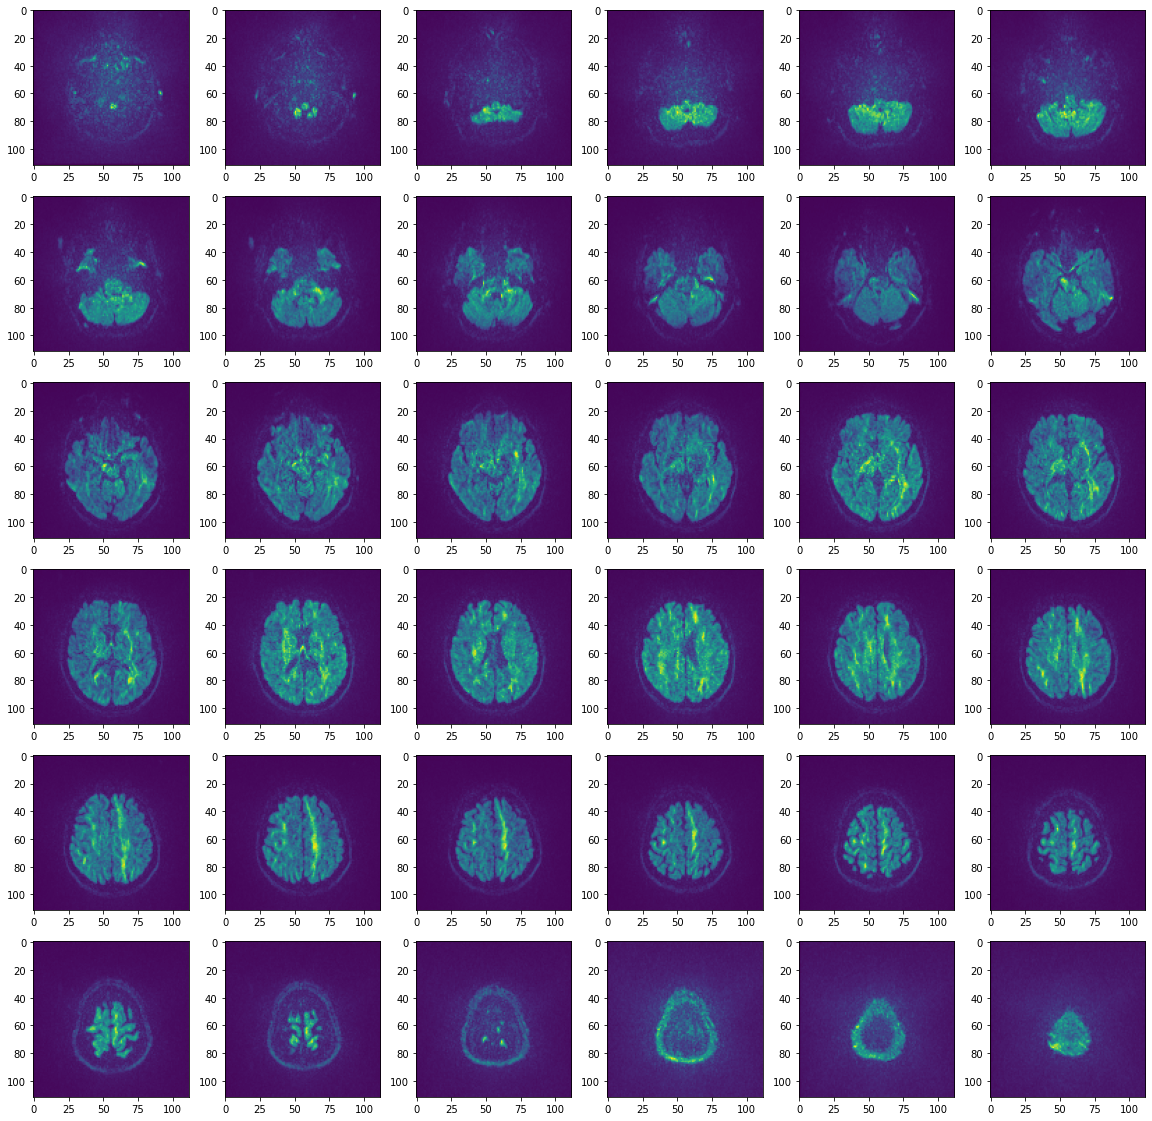

In [37]:


fig, ax = plt.subplots(6,6, figsize=(20,20))
ax = ax.ravel()

subplotno=0

for i in range(1, 72, 2):
    test_image_rot = test_image[:,:,i,5].swapaxes(-2,-1)[...,::-1,:]
    ax[subplotno].imshow(test_image_rot)
    #ax[subplotno].imshow(test_image[:,:,i,5])
    subplotno +=1

## Preprocessing

### Denoising

### Remove Gibbs Artifacts

### Final Step: dwsifslpreproc